# Flight Price Prediction


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from scipy.stats import zscore
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the dataset:

df_train= pd.DataFrame(pd.read_excel("E:\Anuradha\datatrained\Flight_Ticket_Participant_Datasets\Data_Train.xlsx"))
df_test = pd.DataFrame(pd.read_excel("E:\Anuradha\datatrained\Flight_Ticket_Participant_Datasets\Test_set.xlsx"))

In [3]:
df_sample = pd.DataFrame(pd.read_excel("E:\Anuradha\datatrained\Flight_Ticket_Participant_Datasets\Sample_submission.xlsx"))

In [5]:
df_train.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [6]:
df_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [7]:
print("Train Data:", df_train.shape)
print("Test Data:", df_test.shape)

Train Data: (10683, 11)
Test Data: (2671, 10)


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [10]:
df_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [11]:
df_test.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

In [12]:
df_train.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


#### "Price" is only numeric value and we are not applying anything on this a it's the target variable

#### Fill the missing values for both "Traning" and "Test" dataset:

In [13]:
df_train["Route"].value_counts()

DEL → BOM → COK                2376
BLR → DEL                      1552
CCU → BOM → BLR                 979
CCU → BLR                       724
BOM → HYD                       621
                               ... 
BOM → VNS → DEL → HYD             1
BOM → BLR → CCU → BBI → HYD       1
BLR → BOM → IXC → DEL             1
BOM → JDH → JAI → DEL → HYD       1
BOM → JAI → DEL → HYD             1
Name: Route, Length: 128, dtype: int64

In [14]:
df_test["Route"].value_counts()

DEL → BOM → COK                      624
BLR → DEL                            389
CCU → BOM → BLR                      253
CCU → BLR                            172
BOM → HYD                            164
                                    ... 
CCU → DEL → COK → TRV → BLR            1
CCU → BBI → IXR → DEL → BLR            1
BLR → CCU → BBI → HYD → VGA → DEL      1
BLR → BOM → IDR → GWL → DEL            1
CCU → IXR → BBI → BLR                  1
Name: Route, Length: 100, dtype: int64

In [15]:
df_train["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [16]:
# Fill the columns with mode as its categorical data:

df_train["Route"].fillna(df_train["Route"].value_counts().index[0], inplace=True)

In [17]:
df_train["Total_Stops"].fillna(df_train["Total_Stops"].value_counts().index[0], inplace=True)

In [18]:
# check for null value:

df_train.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

<AxesSubplot:>

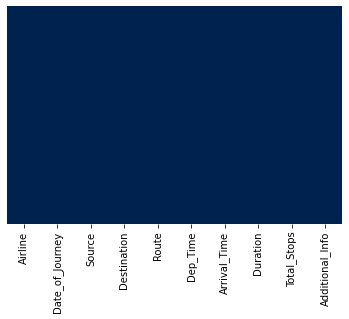

In [19]:
# Using heatmap:
sns.heatmap(df_test.isnull(), yticklabels=False, cbar=False, cmap="cividis")

<AxesSubplot:>

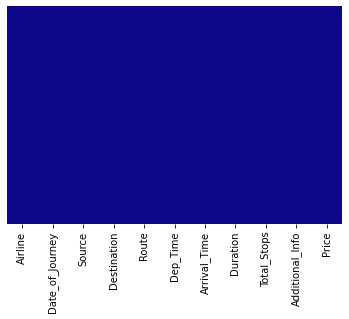

In [20]:
sns.heatmap(df_train.isnull(), yticklabels=False, cbar=False, cmap="plasma")

### Plot with respect to training dataset, we can see that Jet Airways holds a large share of business in this sector with about 36.02 % followed by IndiGo and Air India.

In [21]:
airline_percent = (df_train["Airline"].value_counts()/df_train.shape[0])*100
print(airline_percent)

Jet Airways                          36.029205
IndiGo                               19.217448
Air India                            16.399888
Multiple carriers                    11.195357
SpiceJet                              7.657025
Vistara                               4.483759
Air Asia                              2.986053
GoAir                                 1.815969
Multiple carriers Premium economy     0.121689
Jet Airways Business                  0.056164
Vistara Premium economy               0.028082
Trujet                                0.009361
Name: Airline, dtype: float64


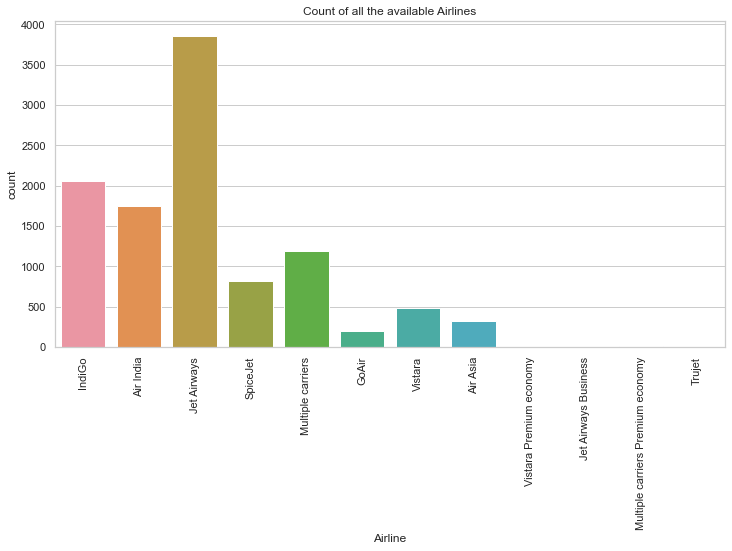

In [22]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.countplot("Airline", data=df_train).set(title='Count of all the available Airlines') 
plt.xticks(rotation=90)
plt.show()

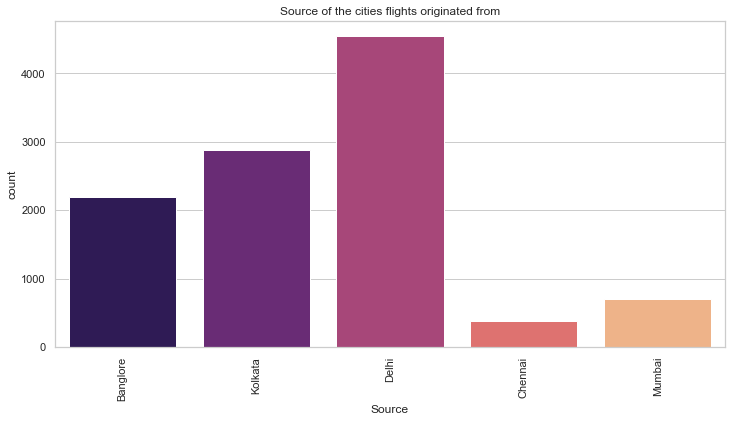

In [23]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.countplot("Source", data=df_train, palette= "magma").set(title='Source of the cities flights originated from') 
plt.xticks(rotation=90)
plt.show()

### various cities and Delhi seems to be ranking at the top followed by Kolkata and then by Bangalore.

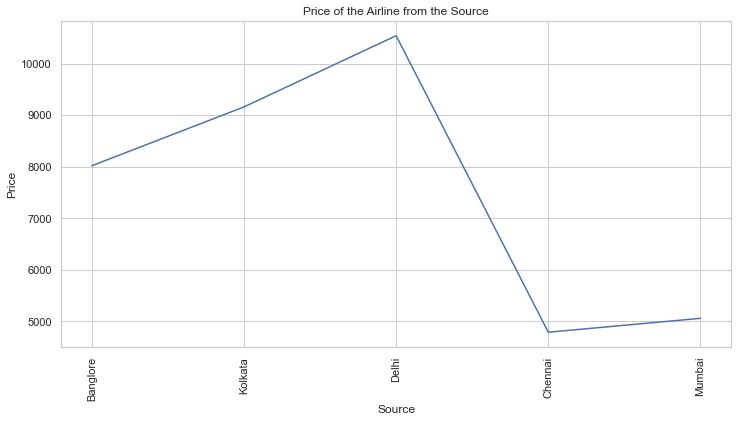

In [24]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_train, x="Source", y="Price", ci=None).set(title='Price of the Airline from the Source')
plt.xticks(rotation=90)
plt.show()

### Plot shows people majorly travel to "Cochin" followed by "Bangalore" and "Delhi".

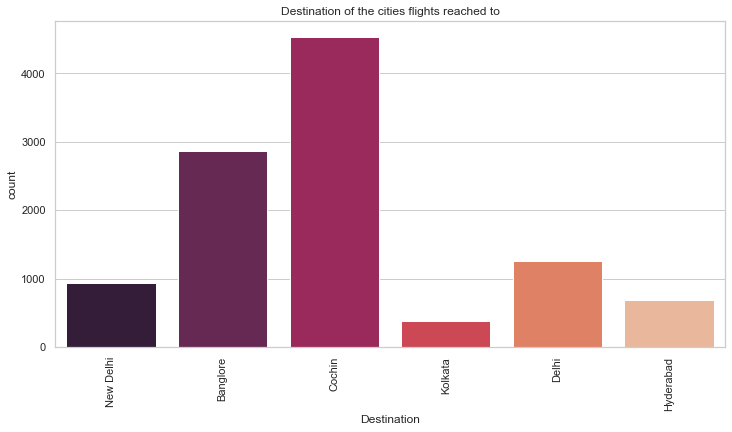

In [25]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.countplot("Destination", data=df_train, palette= "rocket").set(title='Destination of the cities flights reached to') 
plt.xticks(rotation=90)
plt.show()

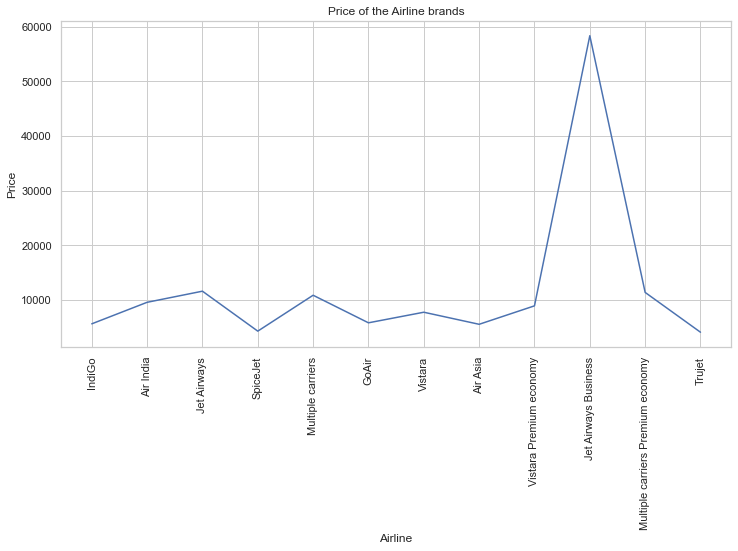

In [26]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_train, x="Airline", y="Price", ci=None).set(title='Price of the Airline brands')
plt.xticks(rotation=90)
plt.show()

### Flights charge roughly 10,000 to 11,000 Rs for ticket, but Jet Airways Business charges more than 55,000 Rs.

#### "Business Class" has a lot of additional benefits.An Economy class doesn't have much benefits and hence people prefer this more as it's relatively cheaper that other class.

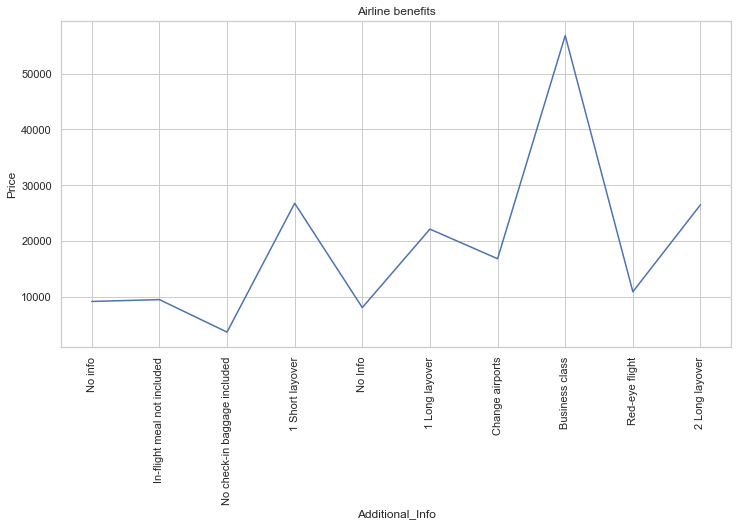

In [27]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data=df_train, x="Additional_Info", y="Price", ci=None).set(title='Airline benefits')
plt.xticks(rotation=90)
plt.show()

### Plot shows us the number of stops given by flights
#### Majority of flights have "one stop" and this shows that flights have reached directly to the destination with more amout of time for halt.

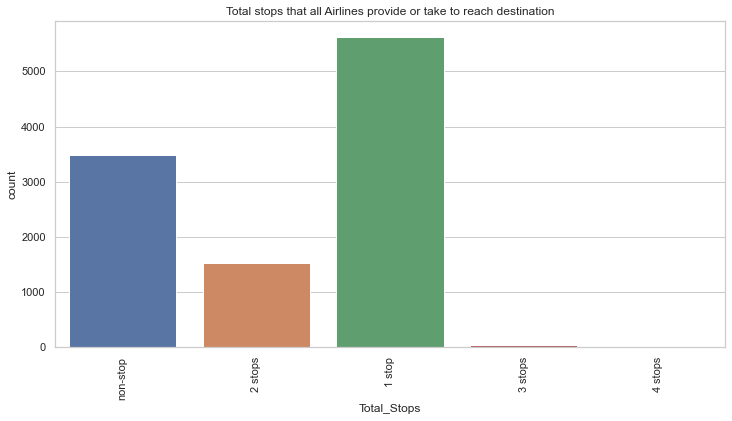

In [28]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.countplot("Total_Stops", data=df_train).set(title='Total stops that all Airlines provide or take to reach destination') 
plt.xticks(rotation=90)
plt.show()

### Plot can see the price distribution across the number of stops.
##### Flights with "one- stop" have more prices compared to other modes of halt.

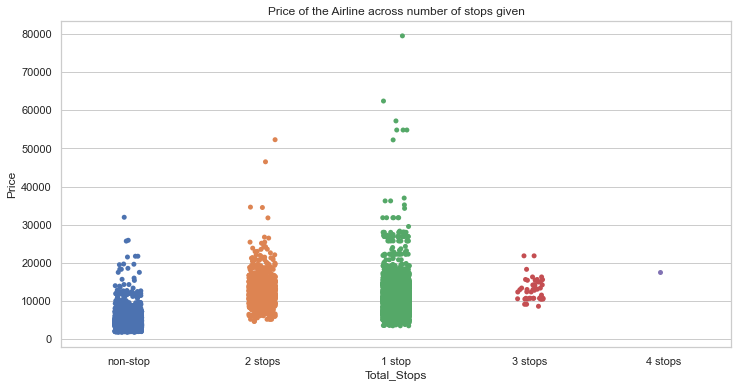

In [29]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.stripplot(x="Total_Stops", y="Price", data=df_train).set(title='Price of the Airline across number of stops given')
plt.show()

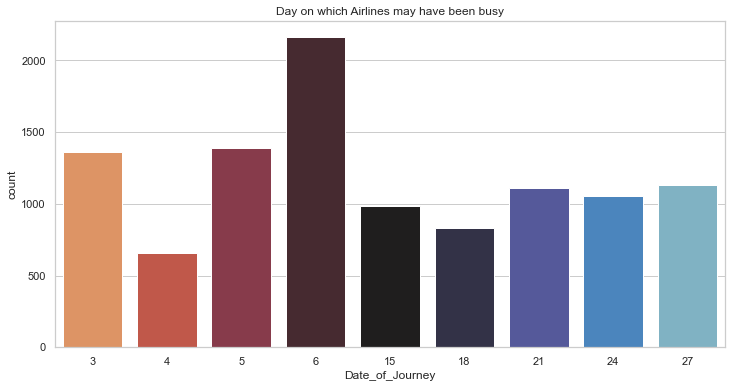

In [30]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x=pd.DatetimeIndex(df_train['Date_of_Journey']).day,
                   data=df_train, palette= "icefire_r").set(title='Day on which Airlines may have been busy') 
plt.show()

### Plot we can observe that January and February months of 2019 hd highest price tickets.

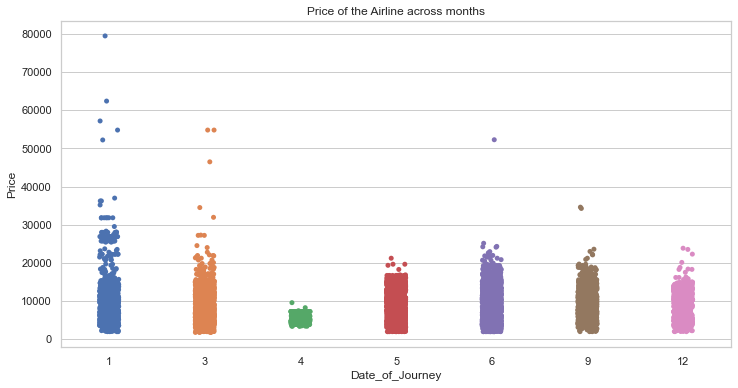

In [31]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
ax = sns.stripplot(x=pd.DatetimeIndex(df_train['Date_of_Journey']).month, 
                   y="Price", data=df_train).set(title='Price of the Airline across months')
plt.show()

#### Displaying the total columns names to select features for encoding

In [32]:
df_train.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

### Encoding the dataset


In [33]:
# LabelEncoder

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [34]:
# Encode the training dataset

df_train.Airline = encoder.fit_transform(df_train.Airline)
df_train.Date_of_Journey = encoder.fit_transform(df_train.Date_of_Journey)
df_train.Source = encoder.fit_transform(df_train.Source)
df_train.Destination = encoder.fit_transform(df_train.Destination)
df_train.Route = encoder.fit_transform(df_train.Route)
df_train.Dep_Time = encoder.fit_transform(df_train.Dep_Time)
df_train.Arrival_Time = encoder.fit_transform(df_train.Arrival_Time)
df_train.Duration = encoder.fit_transform(df_train.Duration)
df_train.Total_Stops = encoder.fit_transform(df_train.Total_Stops)
df_train.Additional_Info = encoder.fit_transform(df_train.Additional_Info)

# Encode the test dataset

df_test.Airline = encoder.fit_transform(df_test.Airline)
df_test.Date_of_Journey = encoder.fit_transform(df_test.Date_of_Journey)
df_test.Source = encoder.fit_transform(df_test.Source)
df_test.Destination = encoder.fit_transform(df_test.Destination)
df_test.Route = encoder.fit_transform(df_test.Route)
df_test.Dep_Time = encoder.fit_transform(df_test.Dep_Time)
df_test.Arrival_Time = encoder.fit_transform(df_test.Arrival_Time)
df_test.Duration = encoder.fit_transform(df_test.Duration)
df_test.Total_Stops = encoder.fit_transform(df_test.Total_Stops)
df_test.Additional_Info = encoder.fit_transform(df_test.Additional_Info)

### Datasets have now been encoded


In [35]:
df_train.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,3,24,0,5,18,211,233,240,4,8,3897
1,1,6,3,0,84,31,906,336,1,8,7662


In [36]:
df_test.head(2)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,4,39,2,1,76,138,150,10,0,5
1,3,10,3,0,65,31,353,248,0,5


In [37]:
# Difference between mean and std also seems fine .

df_train.describe()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
count,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000,10683.000000
mean,3.965927,23.735093,1.952261,1.436113,74.822896,107.980717,869.828419,194.069269,1.458111,7.393054,9087.064121
std,2.352155,12.337763,1.177221,1.474782,36.728405,61.085563,331.509504,108.620556,1.806290,1.214211,4611.359167
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1759.000000
25%,3.000000,14.000000,2.000000,0.000000,48.000000,55.000000,603.000000,106.000000,0.000000,8.000000,5277.000000
50%,4.000000,24.000000,2.000000,1.000000,73.000000,96.000000,937.000000,233.000000,0.000000,8.000000,8372.000000
75%,4.000000,35.000000,3.000000,2.000000,104.000000,164.000000,1141.000000,280.000000,4.000000,8.000000,12373.000000
max,11.000000,43.000000,4.000000,5.000000,127.000000,221.000000,1342.000000,367.000000,4.000000,9.000000,79512.000000


In [38]:
df_test.describe()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
count,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000,2671.000000
mean,3.972669,23.662673,1.961438,1.432797,54.356421,96.249719,435.586672,169.453014,1.422688,4.634594
std,2.295657,12.536017,1.184328,1.467971,27.128993,54.620936,193.250349,93.907162,1.795728,0.760781
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,14.000000,2.000000,0.000000,33.000000,48.000000,276.000000,91.000000,0.000000,5.000000
50%,4.000000,24.000000,2.000000,1.000000,51.000000,88.000000,481.000000,209.000000,0.000000,5.000000
75%,6.000000,35.000000,3.000000,2.000000,76.000000,146.000000,600.000000,241.000000,4.000000,5.000000
max,10.000000,43.000000,4.000000,5.000000,99.000000,198.000000,703.000000,319.000000,4.000000,5.000000


### Distribution of all the columns of dataset

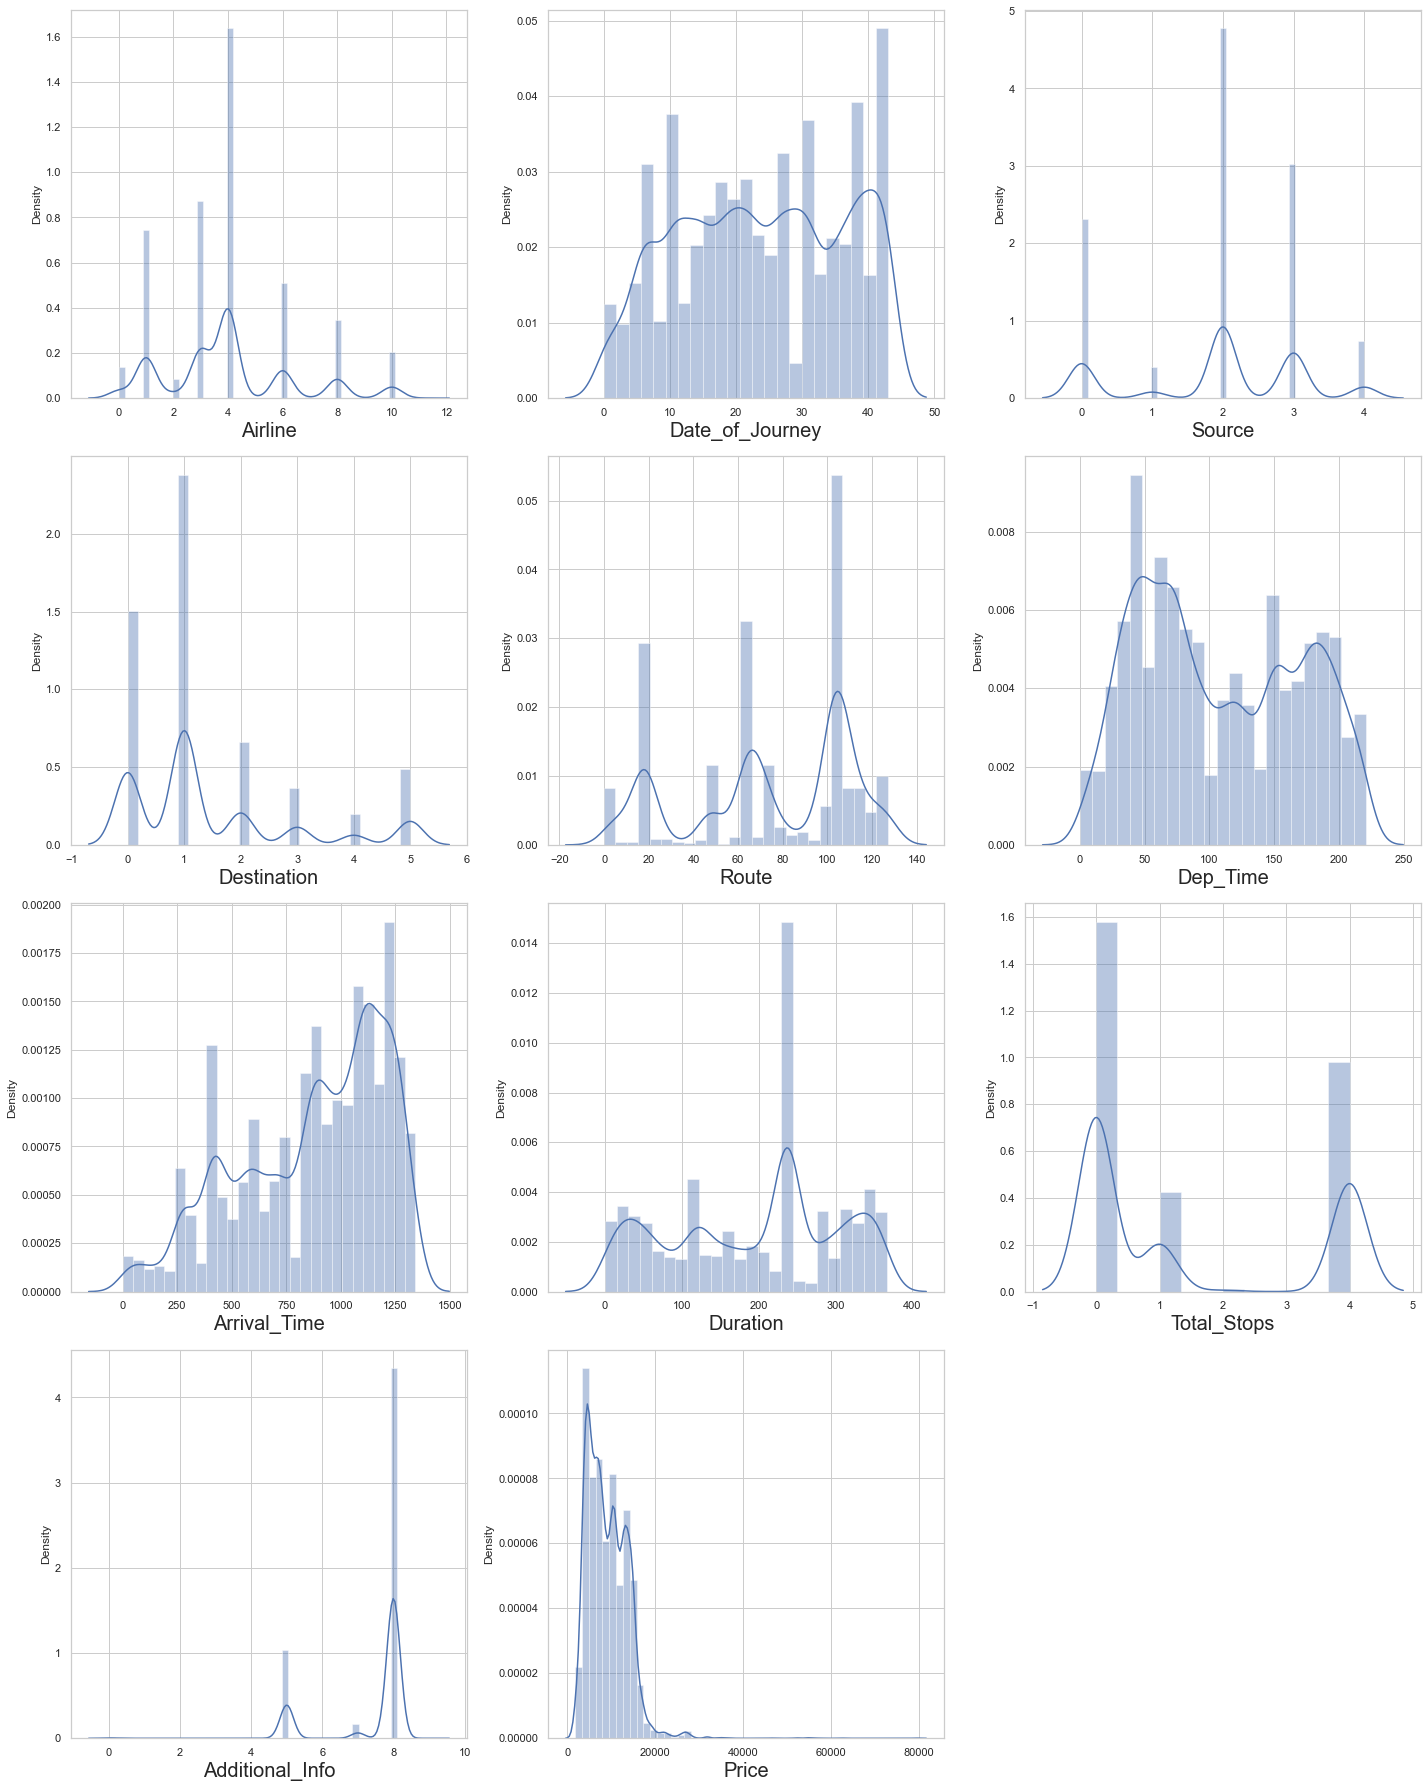

In [39]:
# let us now see the distribution of the "Train dataset"

plt.figure(figsize=(20,25), facecolor="white")
plotnumber = 1

for column in df_train:
    if plotnumber <=11:
        ax = plt.subplot(4,3, plotnumber)
        sns.distplot(df_train[column])
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()

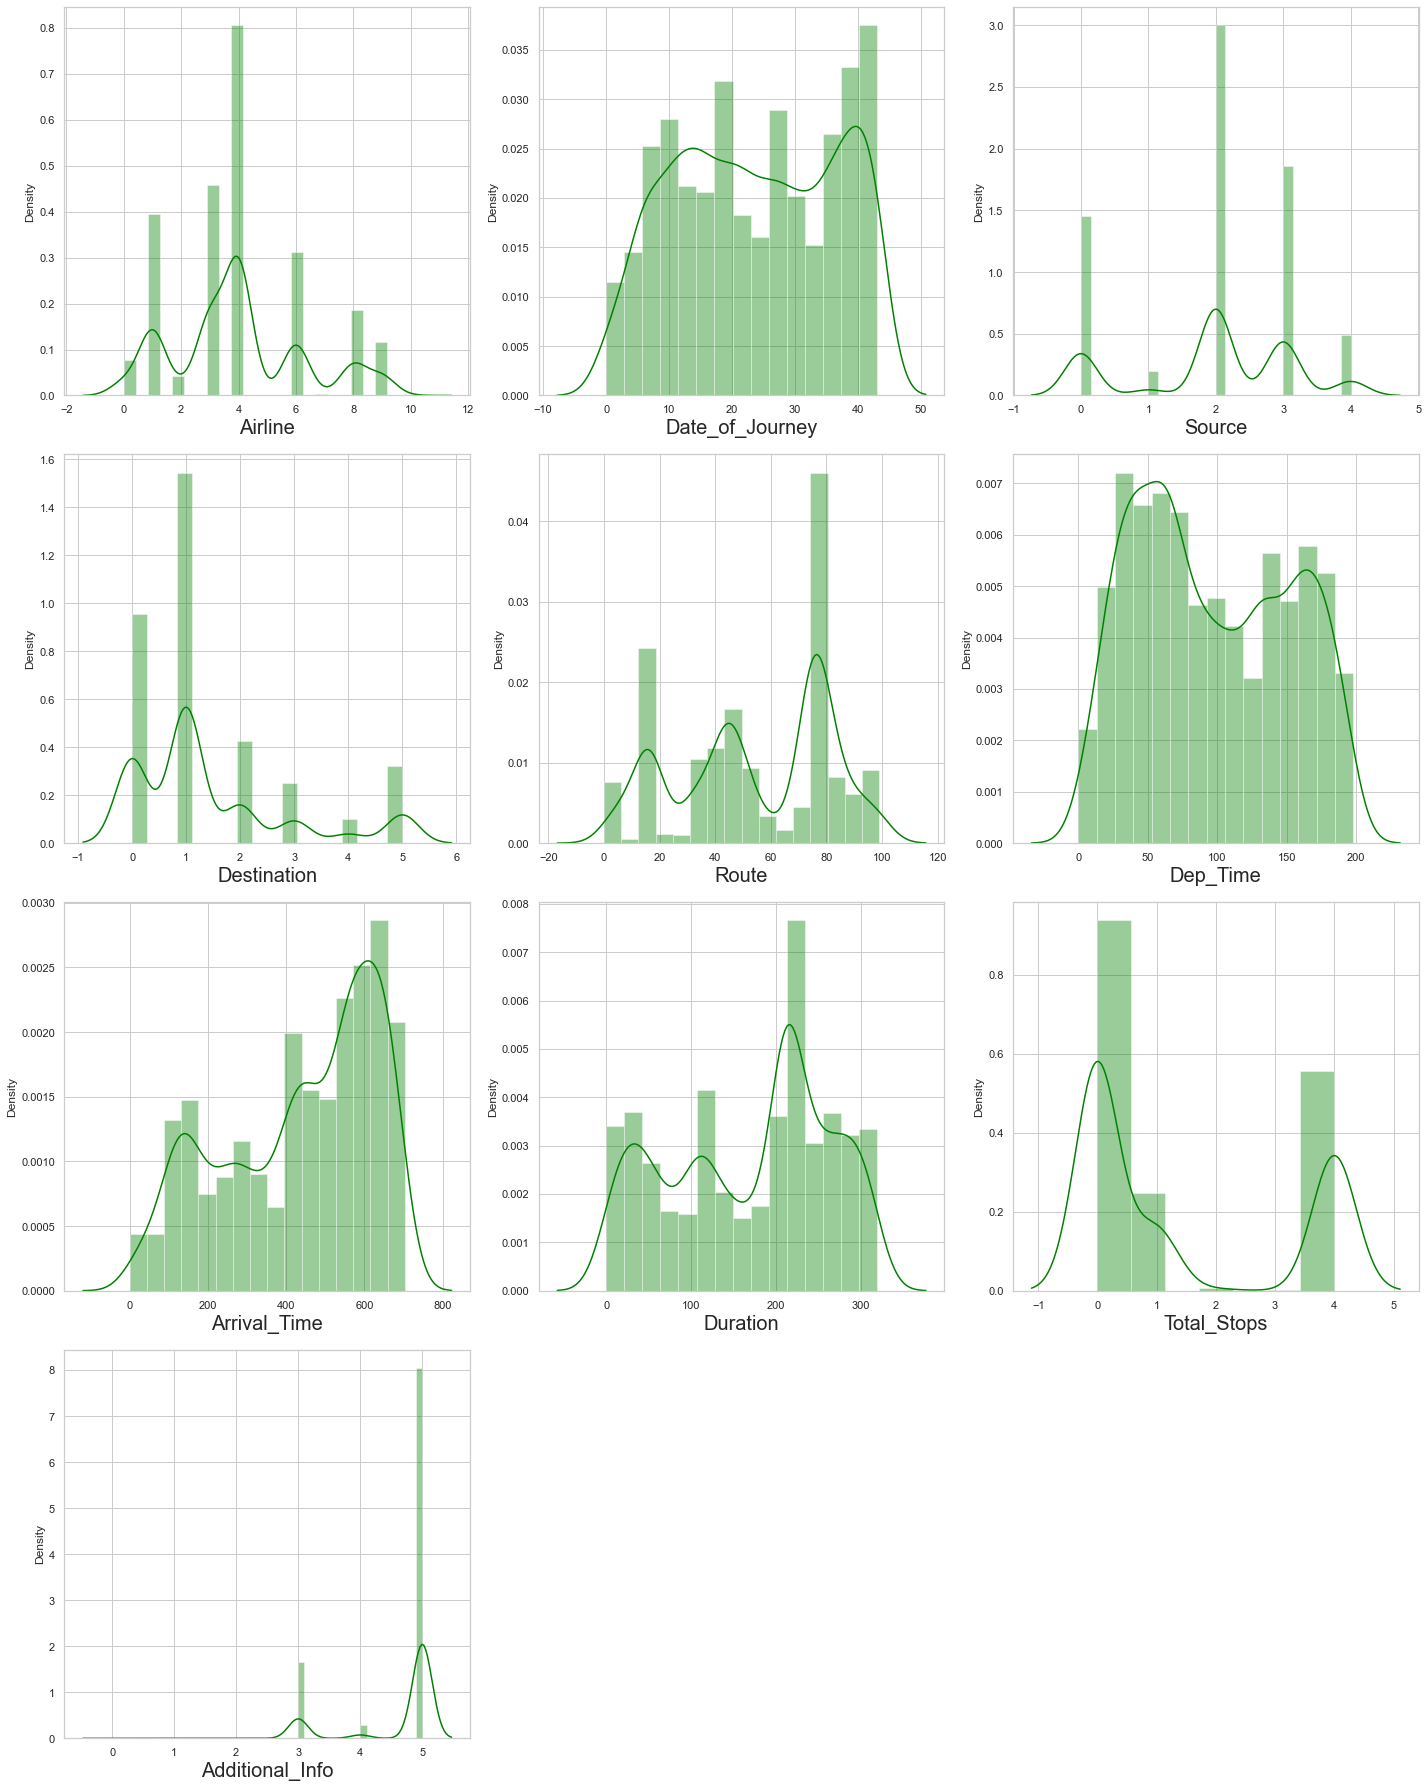

In [40]:
# let us now see the distribution of the "Test dataset"

plt.figure(figsize=(20,25), facecolor="white")
plotnumber = 1

for column in df_test:
    if plotnumber <=11:
        ax = plt.subplot(4,3, plotnumber)
        sns.distplot(df_test[column], color="green")
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()

## Correlation :

### "Route", "Duration" and "Total_Stope" have a string correlation with the target variable "Price".

In [41]:
corr_matrix = df_train.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price              1.000000
Route              0.164118
Arrival_Time       0.027377
Source             0.015998
Dep_Time           0.002949
Date_of_Journey   -0.036942
Airline           -0.039520
Additional_Info   -0.065478
Destination       -0.071112
Duration          -0.144270
Total_Stops       -0.571174
Name: Price, dtype: float64

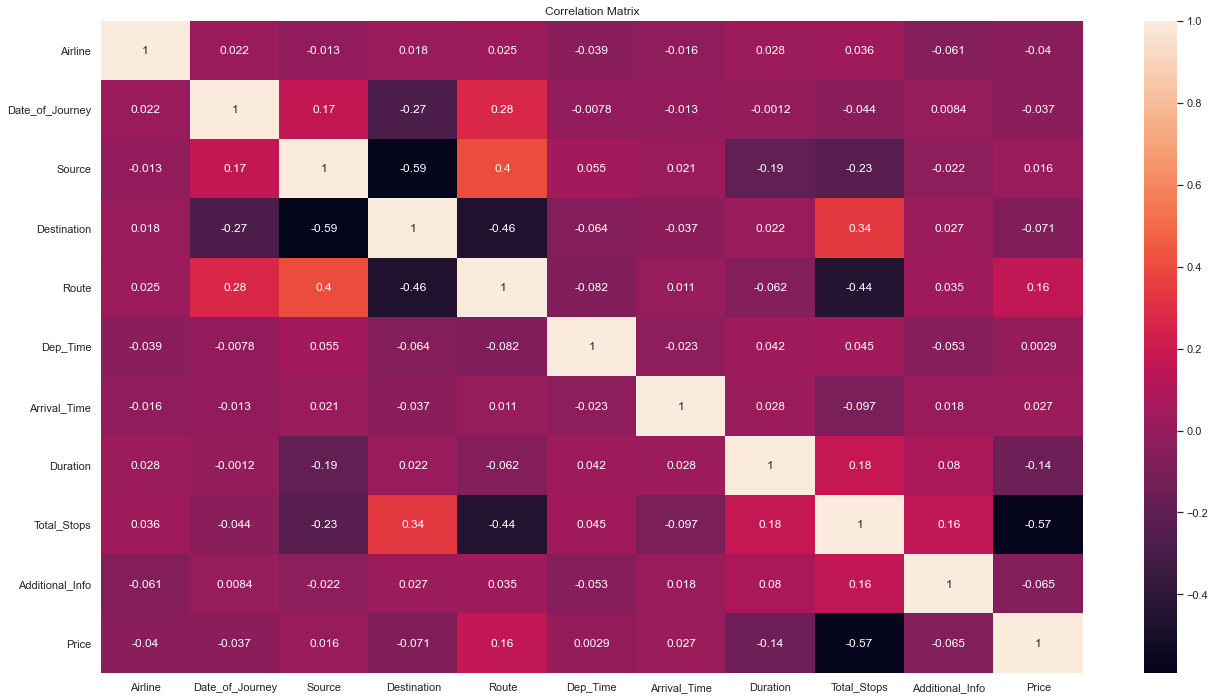

In [42]:
plt.figure(figsize=(22,12))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix")
plt.show()

### Splitting dataset in x (features) and y (target column)


In [43]:
# train & test dataset with featurs:

x = df_train.drop(columns = ["Price"], axis=1)

y = df_train["Price"]


x1 = df_test

In [44]:
# Using StandardScaler

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_scaled1 = scaler.fit_transform(x1)

In [45]:
#Using Train-Test split:

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.30, random_state = 200)

### Regression models

### DecisionTreeRegressor 

In [46]:
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor()
dt_reg.fit(x_train,y_train)

y_pred = dt_reg.predict(x_test)

print("Adjusted R2 squared : ",dt_reg.score(x_train,y_train))
print("Mean Absolute Error (MAE): ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ",np.sqrt(mean_squared_error(y_test, y_pred)))

Adjusted R2 squared :  0.9969229413607383
Mean Absolute Error (MAE):  970.7529381175248
Mean Squared Error (MSE):  5022994.569691454
Root Mean Squared Error (RMSE):  2241.203821541328


### RandomForestRegressor

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(x_train,y_train)

y_pred = rf_reg.predict(x_test)

print("Adjusted R2 squared : ",rf_reg.score(x_train,y_train))
print("Mean Absolute Error (MAE): ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ",np.sqrt(mean_squared_error(y_test, y_pred)))

Adjusted R2 squared :  0.9777895229583251
Mean Absolute Error (MAE):  825.1782485823242
Mean Squared Error (MSE):  2726447.5862374185
Root Mean Squared Error (RMSE):  1651.1958049357497


### ExtraTreesRegressor

In [48]:
from sklearn.ensemble import ExtraTreesRegressor

extra_reg = ExtraTreesRegressor()
extra_reg.fit(x_train,y_train)

y_pred = extra_reg.predict(x_test)
print("Adjusted R2 squared : ",extra_reg.score(x_train,y_train))
print("Mean Absolute Error (MAE): ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ",np.sqrt(mean_squared_error(y_test, y_pred)))

Adjusted R2 squared :  0.9969228834756563
Mean Absolute Error (MAE):  897.4904615184607
Mean Squared Error (MSE):  3068707.0363923046
Root Mean Squared Error (RMSE):  1751.772541282773


### KNN

In [49]:
from sklearn.neighbors import KNeighborsRegressor

k_neigh = KNeighborsRegressor()
k_neigh.fit(x_train,y_train)

y_pred = k_neigh.predict(x_test)

print("Adjusted R2 squared : ",k_neigh.score(x_train,y_train))
print("Mean Absolute Error (MAE): ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ",np.sqrt(mean_squared_error(y_test, y_pred)))

Adjusted R2 squared :  0.7948276200070794
Mean Absolute Error (MAE):  1454.8957878315132
Mean Squared Error (MSE):  5807878.834783153
Root Mean Squared Error (RMSE):  2409.954114663421


### GradientBoostingRegressor

In [51]:
from sklearn.ensemble import GradientBoostingRegressor

grid_reg = GradientBoostingRegressor()
grid_reg.fit(x_train,y_train)

y_pred = grid_reg.predict(x_test)

print("Adjusted R2 squared : ",grid_reg.score(x_train,y_train))
print("Mean Absolute Error (MAE): ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error (MSE): ",mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE): ",np.sqrt(mean_squared_error(y_test, y_pred)))

Adjusted R2 squared :  0.8334371698202327
Mean Absolute Error (MAE):  1295.4342395025033
Mean Squared Error (MSE):  3918106.8349729404
Root Mean Squared Error (RMSE):  1979.420833216863


### Cross validation

In [52]:
from sklearn.model_selection import cross_val_score

In [54]:
scr = cross_val_score(dt_reg, x, y, cv=5)
print("Cross Validation score of DecisionTreeRegressor model is:", scr.mean())

scr = cross_val_score(rf_reg, x, y, cv=5)
print("Cross Validation score of RandomForestRegressor model is:", scr.mean())

scr = cross_val_score(extra_reg, x, y, cv=5)
print("Cross Validation score of ExtraTreesRegressor model is:", scr.mean())

scr = cross_val_score(k_neigh, x, y, cv=5)
print("Cross Validation score of KNeighborsRegressor model is:", scr.mean())

scr = cross_val_score(grid_reg, x, y, cv=5)
print("Cross Validation score of GradientBoostingRegressor model is:", scr.mean())

Cross Validation score of DecisionTreeRegressor model is: 0.8096940198414047
Cross Validation score of RandomForestRegressor model is: 0.8644892918512929
Cross Validation score of ExtraTreesRegressor model is: 0.8591384865534761
Cross Validation score of KNeighborsRegressor model is: 0.5819407946217081
Cross Validation score of GradientBoostingRegressor model is: 0.806177938893104


### Hyper-parameter Tuning :

In [55]:
parameters = {"loss":["ls", "lad", "huber", "quantile"],
              "criterion":["friedman_mse", "mse", "mae"],
              "max_features":["auto", "sqrt", "log2"],
              "n_estimators":[50, 70, 90, 100, 130, 150],
              "random_state":[50, 70, 90, 100, 130, 150],
              "tol":[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
              }

#### Using RandomizedSearchCV :

In [68]:
from sklearn.model_selection import RandomizedSearchCV
RCV = RandomizedSearchCV(GradientBoostingRegressor(), parameters, cv=5, n_iter=10)

In [70]:
RCV.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(),
                   param_distributions={'criterion': ['friedman_mse', 'mse',
                                                      'mae'],
                                        'loss': ['ls', 'lad', 'huber',
                                                 'quantile'],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [50, 70, 90, 100, 130,
                                                         150],
                                        'random_state': [50, 70, 90, 100, 130,
                                                         150],
                                        'tol': [0.1, 0.01, 0.001, 0.0001,
                                                1e-05]})

In [71]:
RCV.best_params_

{'tol': 0.1,
 'random_state': 130,
 'n_estimators': 150,
 'max_features': 'auto',
 'loss': 'huber',
 'criterion': 'friedman_mse'}

### Rebulding the model:

In [72]:
mod_grid_reg = GradientBoostingRegressor(learning_rate= 0.0001, random_state= 50, n_estimators= 150, max_features= "log2",
                                         loss= "huber", criterion= "friedman_mse")

mod_grid_reg.fit(x_train,y_train)
pred = mod_grid_reg.predict(x_test)
pred

array([8485.03020157, 8426.04184585, 8492.00030616, ..., 8476.19064127,
       8490.12282083, 8472.65078396])

In [73]:
# Save Model:

import joblib
joblib.dump(mod_grid_reg,"Flight_Price_Prediction.pkl")

['Flight_Price_Prediction.pkl']

In [74]:
# Nwe Model :

model = joblib.load("Flight_Price_Prediction.pkl")

In [75]:
# df_test is the traning dataset, a different csv 

prediction = model.predict(df_test)

prediction=pd.DataFrame(prediction)
prediction

,0
0,8477.681936
1,8483.980819
2,8477.681936
3,8477.681936
4,8418.507734
...,...
2666,8486.025325
2667,8427.601182
2668,8477.681936
2669,8477.294741
